In [34]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [35]:
train_path = "./Data/Data_src1/train"
valid_path = "./Data/Data_src1/valid"
test_path = "./Data/Data_src1/test"

In [36]:
# Transformaitions on training set 'image augmentation' - prevent overfitting (high accuracy on training set but not on test set) 
# ImageDataGenerator - generate batches of real time data (e.g. 32 images) - applies augmentation - e.g. zoom range, shear range, horizontal flip, rescale i.e. feature scaling (0-255 here)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# flow from directory connects to directory
# Resizing images to make the model faster
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 30250 images belonging to 2 classes.


In [37]:
# No transformations for test images, but requires feature scaling
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_set = validation_datagen.flow_from_directory(valid_path,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 6300 images belonging to 2 classes.


In [38]:
# No transformations for test images, but requires feature scaling
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 6300 images belonging to 2 classes.


CNN DEFINITION

In [ ]:
# Initializing
cnn = tf.keras.models.Sequential()

In [ ]:
# Convolution
# filters = kernels, activation = relu, input shape = 64x64, 3 (rgb)
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=(64,64,3)))

In [ ]:
# Pooling
# Pool size = 2,2 (frame size), stride = 2 (# pixels frame shifts to right)
# padding = 'valid' (ignore) OR same (add empty pixels to make the frame complete)
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [ ]:
# Second convolutional layer
# No insput shape parameter required in second layer
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

In [ ]:
# Flattening
# Put results in 1D vector
cnn.add(tf.keras.layers.Flatten())

In [ ]:
# Full connection
cnn.add(tf.keras.layers.Dense(units=128,activation='relu'))

In [ ]:
# Output layer
cnn.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

CNN TRAINING

In [ ]:
# compile - stochastic gradient optimizer - binary cross entropy loss - accuracy
cnn.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [48]:
# train and evaluate
# cnn.fit(x=training_set, validation_data=validation_set, epochs=25)
history = cnn.fit(x=training_set, validation_data=validation_set, epochs=25)

Epoch 1/25
946/946 [==============================] - 1486s 2s/step - loss: 0.0702 - accuracy: 0.9724 - val_loss: 0.1501 - val_accuracy: 0.9552
Epoch 2/25
946/946 [==============================] - 121s 128ms/step - loss: 0.0680 - accuracy: 0.9746 - val_loss: 0.2161 - val_accuracy: 0.9394
Epoch 3/25
946/946 [==============================] - 121s 128ms/step - loss: 0.0678 - accuracy: 0.9762 - val_loss: 0.1837 - val_accuracy: 0.9537
Epoch 4/25
946/946 [==============================] - 137s 144ms/step - loss: 0.0654 - accuracy: 0.9758 - val_loss: 0.1732 - val_accuracy: 0.9481
Epoch 5/25
946/946 [==============================] - 134s 142ms/step - loss: 0.0607 - accuracy: 0.9772 - val_loss: 0.1402 - val_accuracy: 0.9600
Epoch 6/25
946/946 [==============================] - 134s 141ms/step - loss: 0.0608 - accuracy: 0.9777 - val_loss: 0.1680 - val_accuracy: 0.9517
Epoch 7/25
946/946 [==============================] - 134s 142ms/step - loss: 0.0587 - accuracy: 0.9792 - val_loss: 0.2386 - v

In [ ]:
cnn.save('saved_model/cnn_25epochs_adam_bincross')

INFERENCE

In [39]:
training_set.class_indices

{'nowildfire': 0, 'wildfire': 1}

In [40]:
cnn = tf.keras.models.load_model('saved_model/cnn_25epochs_adam_bincross')

In [8]:
import numpy as np
import keras.utils as image

image_path=test_path+'/wildfire/-59.03238,51.85132.jpg'
test_image = image.load_img(image_path, target_size=(64,64)) #img size must be 64x64
test_image = image.img_to_array(test_image) #should be an array
test_image = np.expand_dims(test_image,axis=0) #must be an batch - so adding extra dimension
result = cnn.predict(test_image/255.0) #must normalize the test image

# inside a batch [0], first prediction [0]
if result[0][0] > 0.5:
    prediction = 'wildfire'
else:
    prediction = 'no wildfire'

1/1 [==============================] - 0s 334ms/step


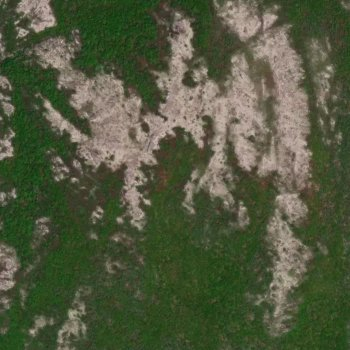

0.6248719
wildfire


In [9]:
from IPython.display import Image, display
display(Image(filename=image_path))
print(result[0][0])
print(prediction)

In [10]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [11]:
result = cnn.predict(test_set) 

197/197 [==============================] - 93s 476ms/step


In [12]:
print(result)

[[1.9307758e-13]
 [9.9643183e-01]
 [1.5443339e-16]
 ...
 [1.4439872e-16]
 [9.8271734e-01]
 [4.0868693e-12]]


In [19]:
import re

image_paths = test_set.filenames
# results_disp = result[:5]
result_formatted = []

for i in range(len(result)):
    if result[i][0] >= 0.5:
        prediction_label = 'wildfire'
    else:
        prediction_label = 'no wildfire'

    result_obj = {
        "image_path": test_path + "/" + re.sub(r'\\', '/', image_paths[i]),
        "prediction": result[i],
        "prediction_label":prediction_label
    }
    
    # display(Image(filename=result_obj['image_path']))
    # print("Image Path:", result_obj['image_path'])
    # print("Prediction:", result_obj['prediction'])
    # print("Prediction Label:", result_obj['prediction_label'])

    result_formatted.append(result_obj)

In [33]:
import pandas as pd
output_file = './model_predictions/cnn_25epochs_adam_bincross/result_formatted.csv'
df = pd.DataFrame(result_formatted)
df.to_csv(output_file)

ACCURACY

In [ ]:
cnn = tf.keras.models.load_model('saved_model/cnn_25epochs_adam_bincross')

In [43]:
df = pd.read_csv('./model_predictions/cnn_25epochs_adam_bincross/result_formatted.csv')

,Unnamed: 0,image_path,prediction,prediction_label
0,0,"./Data/Data_src1/test/nowildfire/-113.91777,50...",[1.9307758e-13],no wildfire
1,1,"./Data/Data_src1/test/nowildfire/-113.91782,50...",[0.9964318],wildfire
2,2,"./Data/Data_src1/test/nowildfire/-113.91793,51...",[1.5443339e-16],no wildfire


In [55]:
df['label_bool'] = df['image_path'].apply(lambda path: 1 if '/test/wildfire/' in path else 0)
df['prediction_label_bool'] = df['prediction_label'].apply(lambda label: 1 if label == 'wildfire' else 0)

In [56]:
df.head(3)

,Unnamed: 0,image_path,prediction,prediction_label,image_path_indicator,prediction_label_indicator,label_bool,prediction_label_bool
0,0,"./Data/Data_src1/test/nowildfire/-113.91777,50...",[1.9307758e-13],no wildfire,0,0,0,0
1,1,"./Data/Data_src1/test/nowildfire/-113.91782,50...",[0.9964318],wildfire,0,1,0,1
2,2,"./Data/Data_src1/test/nowildfire/-113.91793,51...",[1.5443339e-16],no wildfire,0,0,0,0


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [47]:
loss, accuracy = cnn.evaluate(test_set, verbose=1)
loss_v, accuracy_v = cnn.evaluate(validation_set, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

197/197 [==============================] - 290s 1s/step - loss: 0.2103 - accuracy: 0.9425
Validation: accuracy = 0.942540  ;  loss_v = 0.210317
Test: accuracy = 0.947778  ;  loss = 0.191884


Asked chat GPT to generate code for some stuff below :P lets see..

In [51]:
import matplotlib.pyplot as plt

def plot_model_history(history):
    # Retrieve the training metrics from the history object
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    # Retrieve the validation metrics if available
    if 'val_loss' in history.history and 'val_accuracy' in history.history:
        val_loss = history.history['val_loss']
        val_accuracy = history.history['val_accuracy']

        # Plot training and validation metrics
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy, label='Training Accuracy')
        plt.plot(val_accuracy, label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    else:
        # Plot only the training metrics if validation metrics are not available
        plt.figure(figsize=(6, 4))
        plt.plot(train_loss, label='Training Loss')
        plt.plot(train_accuracy, label='Training Accuracy')
        plt.title('Training Metrics')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.legend()

    plt.tight_layout()
    plt.show()

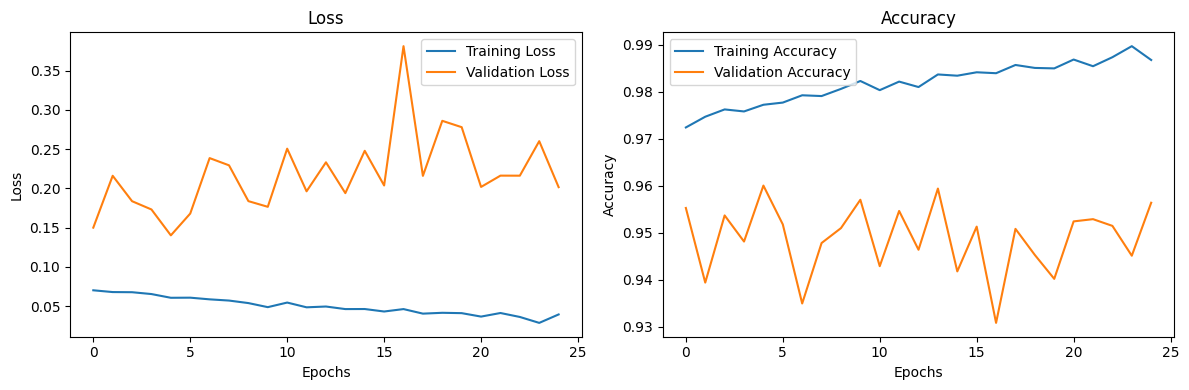

In [52]:
plot_model_history(history)

In [66]:

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],horizontalalignment="center",color="black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

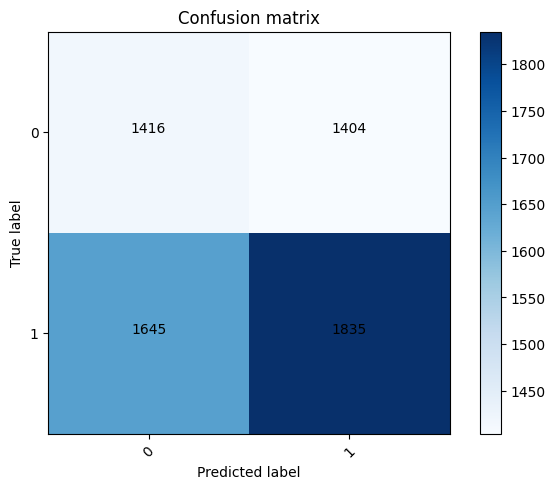

In [67]:
pred = df['prediction_label_bool']
label = df['label_bool']
confusion_mtx = confusion_matrix(label, pred)
plot_confusion_matrix(confusion_mtx, classes = range(2)) 

Text(0, 0.5, 'Fraction classified incorrectly')

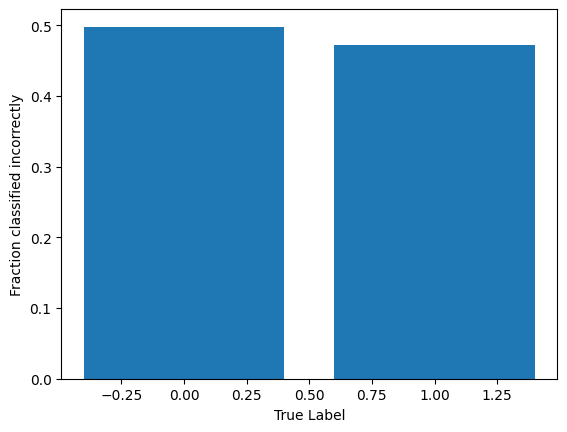

In [61]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(2),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')